# Getting started with astir

## Table of Contents:
* [0 Loading necessary libraries](#0.-Load-necessary-libraries)
* [1 Load data](#1.-Load-data)
* [2 Fitting cell type](#2.-Fitting-cell-types)
* [3 Fitting cell state](#3.-Fitting-cell-state)
* [4 Saving results](#4.-Saving-results)
* [5 Accessing internal functions and data](#5.-Accessing-internal-functions-and-data)
* [6 Saving models](#6.-Saving-models)
* [7 Plot clustermap of expression data](#7.-Plot-clustermap-of-expression-data)
* [8 Hierarchical model specification](#8.-Hierarchical-model-specification)
* [9 Using astir as command line tool](#9.-Using-astir-as-command-line-tool)

## 0. Load necessary libraries <a class="anchor" id="0.-Load-necessary-libraries"></a>

In [1]:
# !pip install -e ../../..
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from astir.data import from_csv_yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Load data <a class="anchor" id="1.-Load-data"></a>

We start by reading expression data in the form of a csv file and marker gene information in the form of a yaml file:

In [3]:
expression_mat_path = "../../../astir/tests/test-data/sce.csv"
# expression_mat_path = "data/sample_data.csv"
yaml_marker_path = "../../../astir/tests/test-data/jackson-2020-markers.yml"

.. note:: 
    Expression data should already be cleaned and normalized. In our workflow, we perform this by a log-transformation of the data with a pseudocount of 1 (i.e. `log(x+1)`), followed by winsorization at the (1%,99%) percentiles.

We can view both the expression data and marker data:

In [4]:
!head -n 20 ../../../astir/tests/test-data/jackson-2020-markers.yml


cell_states:
  RTK_signalling:
    - Her2
    - EGFR
  proliferation:
    - Ki-67
    - phospho Histone
  mTOR_signalling:
    - phospho mTOR
    - phospho S6
  apoptosis:
    - cleaved PARP
    - Cleaved Caspase3

cell_types:
  stromal:
    - Vimentin
    - Fibronectin
  B cells:


In [5]:
pd.read_csv(expression_mat_path, index_col=0)[['EGFR','E-Cadherin', 'CD45', 'Cytokeratin 5']].head()

,EGFR,E-Cadherin,CD45,Cytokeratin 5
BaselTMA_SP41_186_X5Y4_3679,0.346787,0.938354,0.227730,0.095283
BaselTMA_SP41_153_X7Y5_246,0.833752,1.364884,0.068526,0.124031
BaselTMA_SP41_20_X12Y5_197,0.110006,0.177361,0.301222,0.052750
BaselTMA_SP41_14_X1Y8_84,0.282666,1.122174,0.606941,0.093352
BaselTMA_SP41_166_X15Y4_266,0.209066,0.402554,0.588273,0.064545


Then we can create an astir object using the `from_csv_yaml` function. For more data loading options, see the data loading tutorial.

In [6]:
ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
print(ast)

Astir object, 6 cell types, 4 cell states, 100 cells


## 2. Fitting cell types <a class="anchor" id="2.-Fitting-cell-types"></a>

To fit cell types, simply call

In [7]:
ast.fit_type(max_epochs=10, n_init=3, n_init_epochs=2)

training restart (final): 100%|██████████| 10/10 [87.87epochs/s, current loss: 709.0]
/Users/sunyunlee/Desktop/astir/astir/astir.py:192: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


.. note:: 
    **Controlling inference**
    There are many different options for controlling inference in the `fit_type` function, including
    `max_epochs` (maximum number of epochs to train),
    `learning_rate` (ADAM optimizer learning rate),
    `batch_size` (minibatch size),
    `delta_loss` (stops iteration once the change in loss falls below this value),
    `n_inits` (number of restarts using random initializations).
    For full details, see the function documentation.

We should always plot the losses to assess convergence:

Text(0.5, 0, 'Epoch')

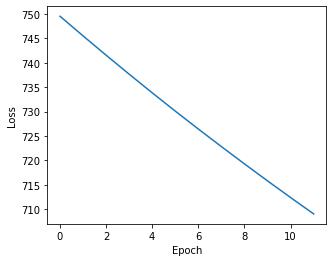

In [8]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

We can then get cell type assignment probabilities by calling

In [9]:
assignments = ast.get_celltype_probabilities()
assignments

,stromal,B cells,T cells,macrophage,epithelial(basal),epithelial(luminal),Other
BaselTMA_SP41_186_X5Y4_3679,0.088444,0.084654,0.198811,0.105010,0.199379,0.119610,0.204091
BaselTMA_SP41_153_X7Y5_246,0.110921,0.156938,0.193806,0.122539,0.200939,0.114491,0.100367
BaselTMA_SP41_20_X12Y5_197,0.099029,0.107530,0.210399,0.135788,0.174190,0.126138,0.146926
BaselTMA_SP41_14_X1Y8_84,0.117755,0.119934,0.221191,0.103741,0.150916,0.140125,0.146337
BaselTMA_SP41_166_X15Y4_266,0.102338,0.106135,0.221755,0.135476,0.157753,0.125728,0.150815
...,...,...,...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,0.100268,0.128181,0.204113,0.140633,0.170518,0.111839,0.144448
BaselTMA_SP41_141_X11Y2_2596,0.112603,0.143363,0.201669,0.148209,0.161044,0.116404,0.116708
BaselTMA_SP41_100_X15Y5_170,0.111955,0.130958,0.203715,0.144000,0.163306,0.119814,0.126253
BaselTMA_SP41_14_X1Y8_2604,0.076987,0.084889,0.218953,0.114034,0.200917,0.130515,0.173706


We can also visualize the assignment probabilities using a heatmap:

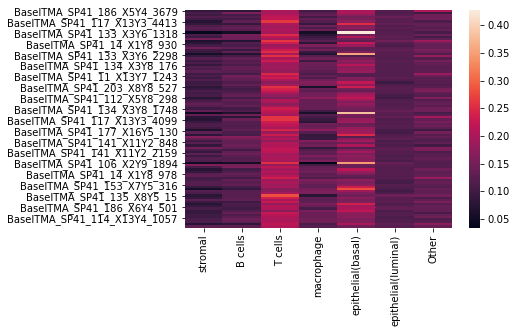

In [10]:
sns.heatmap(assignments)

where each row corresponds to a cell, and each column to a cell type, with the entry being the probability of that cell belonging to a particular cell type.

To fetch an array corresponding to the most likely cell type assignments, call

In [11]:
ast.get_celltypes()

,cell_type
BaselTMA_SP41_186_X5Y4_3679,Unknown
BaselTMA_SP41_153_X7Y5_246,Unknown
BaselTMA_SP41_20_X12Y5_197,Unknown
BaselTMA_SP41_14_X1Y8_84,Unknown
BaselTMA_SP41_166_X15Y4_266,Unknown
...,...
BaselTMA_SP41_114_X13Y4_1057,Unknown
BaselTMA_SP41_141_X11Y2_2596,Unknown
BaselTMA_SP41_100_X15Y5_170,Unknown
BaselTMA_SP41_14_X1Y8_2604,Unknown


### Cell type diagnostics

It is important to run diagnostics to ensure that cell types express their markers at higher levels than other cell types. To do this, run the `diagnostics_celltype()` function, which will alert to any issues if a cell type doesn't express its marker signficantly higher than an alternative cell type (for which that protein isn't a marker):

In [12]:
ast.diagnostics_celltype().head(n=10)

,feature,should be expressed higher in,than,mean cell type 1,mean cell type 2,p-value,note


.. note:: 
    In this tutorial, we end up with many "Only 1 cell in a type: comparison not possible" notes - this is simply because the small dataset size results in only a single cell assigned to many types, making statistical testing infeasible.

Calling `ast.diagnostics_celltype()` returns a `pd.DataFrame`, where each column corresponds to a particular protein and two cell types, with a warning if the protein is not expressed at higher levels in the cell type for which it is a marker than the cell type for which it is not.

The diagnostics:

1. Iterates through every cell type and every marker for that cell type

2. Given a cell type *c* and marker *g*, find the set of cell types *D* that don't have *g* as a marker

3. For each cell type *d* in *D*, perform a t-test between the expression of marker *g* in *c* vs *d*

4. If *g* is not expressed significantly higher (at significance *alpha*), output a diagnostic explaining this for further investigation.

If multiple issues are found, the markers and cell types may need refined.

## 3. Fitting cell state <a class="anchor" id="3.-Fitting-cell-state"></a>

Similarly as before, to fit cell state, call

In [13]:
ast.fit_state(batch_size = 1024, learning_rate=1e-3, max_epochs=10)

/Users/sunyunlee/Desktop/astir/astir/astir.py:265: UserWarning: Delta loss batch size is greater than the number of epochs
  warnings.warn(
/Users/sunyunlee/Desktop/astir/astir/models/cellstate.py:257: UserWarning: Delta loss batch size is greater than the number of epochs
  warnings.warn("Delta loss batch size is greater than the number of epochs")
training restart (final): 100%|██████████| 10/10 [98.00epochs/s, current loss: 81.7]
/Users/sunyunlee/Desktop/astir/astir/astir.py:327: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


and similary plot the losses via

Text(0.5, 0, 'Epoch')

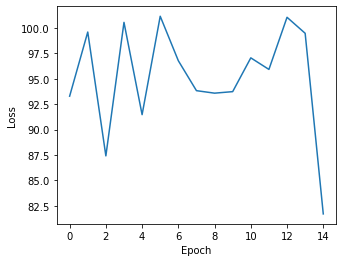

In [14]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_state_losses())), ast.get_state_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

and cell state assignments can be inferred via

In [15]:
states = ast.get_cellstates()
states

,RTK_signalling,proliferation,mTOR_signalling,apoptosis
BaselTMA_SP41_186_X5Y4_3679,0.568386,0.900861,0.656078,0.548110
BaselTMA_SP41_153_X7Y5_246,0.421357,0.000000,0.524859,0.820946
BaselTMA_SP41_20_X12Y5_197,0.944829,0.561159,0.979277,0.778787
BaselTMA_SP41_14_X1Y8_84,0.858426,0.705787,0.938068,0.697319
BaselTMA_SP41_166_X15Y4_266,0.933672,0.574031,0.980568,0.764967
...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,0.881551,0.447002,0.899008,1.000000
BaselTMA_SP41_141_X11Y2_2596,0.767853,0.684847,0.856773,0.722046
BaselTMA_SP41_100_X15Y5_170,0.952977,0.548220,0.977899,0.786169
BaselTMA_SP41_14_X1Y8_2604,0.836241,0.692617,0.908256,0.700867


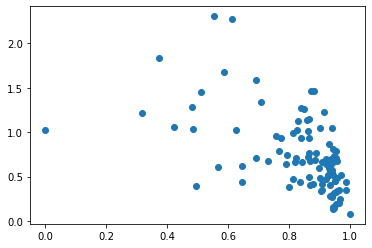

In [16]:
plt.scatter(
    states['RTK_signalling'],
    ast.get_state_dataset().get_exprs_df()['Her2']
)

### Cell state diagnostics

It is important to run diagnostics on cell states model for the same reasons
stated for the cell type model. `Astir.diagnostics_cellstate()` spots any non
 marker protein and pathway pairs whose expressions are higher than those of
 the marker proteins of the pathway.

In [17]:
ast.diagnostics_cellstate().head(n=10)

,pathway,protein A,correlation of protein A,protein B,correlation of protein B,note
0,RTK_signalling,Her2,-0.542371,Ki-67,-0.062491,Her2 is marker for RTK_signalling but Ki-67 isn't
1,RTK_signalling,Her2,-0.542371,phospho S6,-0.519752,Her2 is marker for RTK_signalling but phospho ...
2,proliferation,Ki-67,0.241679,Her2,0.344042,Ki-67 is marker for proliferation but Her2 isn't
3,proliferation,Ki-67,0.241679,phospho S6,0.411222,Ki-67 is marker for proliferation but phospho ...
4,proliferation,Ki-67,0.241679,phospho mTOR,0.316836,Ki-67 is marker for proliferation but phospho ...
5,mTOR_signalling,phospho mTOR,-0.776636,Cleaved Caspase3,-0.557334,phospho mTOR is marker for mTOR_signalling but...
6,mTOR_signalling,phospho mTOR,-0.776636,EGFR,-0.412919,phospho mTOR is marker for mTOR_signalling but...
7,mTOR_signalling,phospho mTOR,-0.776636,Her2,-0.405998,phospho mTOR is marker for mTOR_signalling but...
8,mTOR_signalling,phospho mTOR,-0.776636,Ki-67,-0.012072,phospho mTOR is marker for mTOR_signalling but...
9,mTOR_signalling,phospho mTOR,-0.776636,cleaved PARP,-0.557334,phospho mTOR is marker for mTOR_signalling but...


Calling `ast.diagnostics_cellstate()` returns a `pd.DataFrame`, where each
column corresponds to a particular protein and two cell types, with a warning
 if the protein is not expressed at higher levels in the cell state for which
 it is a marker than the cell state for which it is not.

The diagnostics:

1. Get correlations between all cell states and proteins

2. For each cell state *c*, get the smallest correlation with marker *g*

3. For each cell state *c* and its non marker *g*, find any correlation that is
bigger than those smallest correlation for *c*.

4. Any *c* and *g* pairs found in step 3 will be included in the output of
`Astir.diagnostics_cellstate()`, including an explanation.

If multiple issues are found, the markers and cell states may need refined.


## 4. Saving results <a class="anchor" id="4.-Saving-results"></a>

Both cell type and cell state information can easily be saved to disk via

In [18]:
ast.type_to_csv("data/cell-types.csv")
ast.state_to_csv("data/cell-states.csv")

In [19]:
!head -n 3 data/cell-types.csv

,cell_type
BaselTMA_SP41_186_X5Y4_3679,Unknown
BaselTMA_SP41_153_X7Y5_246,Unknown


In [20]:
!head -n 3 data/cell-states.csv

,RTK_signalling,proliferation,mTOR_signalling,apoptosis
BaselTMA_SP41_186_X5Y4_3679,0.5683861877028941,0.9008611646823064,0.656078413193121,0.5481102160359178
BaselTMA_SP41_153_X7Y5_246,0.42135746208636826,0.0,0.5248592191573492,0.8209456743672588


where the first (unnamed) column always corresponds to the cell name/ID.

## 5. Accessing internal functions and data <a class="anchor" id="5.-Accessing-internal-functions-and-data"></a>

Data stored in `astir` objects is in the form of an `SCDataSet`. These can be retrieved via

In [21]:
celltype_data = ast.get_type_dataset()
celltype_data

and similarly for cell state via `ast.get_state_dataset()`.

These have several helper functions to retrieve relevant information to the dataset:

In [22]:
celltype_data.get_cell_names()[0:4] # cell names

['BaselTMA_SP41_186_X5Y4_3679',
 'BaselTMA_SP41_153_X7Y5_246',
 'BaselTMA_SP41_20_X12Y5_197',
 'BaselTMA_SP41_14_X1Y8_84']

In [23]:
celltype_data.get_classes() # cell type names

['stromal',
 'B cells',
 'T cells',
 'macrophage',
 'epithelial(basal)',
 'epithelial(luminal)']

In [24]:
print(celltype_data.get_n_classes()) # number of cell types
print(celltype_data.get_n_features()) # number of features / proteins

6
14


In [25]:
celltype_data.get_exprs() # Return a torch tensor corresponding to the expression data used

tensor([[0.1026, 0.1004, 0.2277,  ..., 0.6097, 2.2151, 0.7714],
        [0.1081, 0.0176, 0.0685,  ..., 1.0622, 0.5026, 3.9632],
        [0.0498, 0.0943, 0.3012,  ..., 0.1601, 0.8102, 0.0481],
        ...,
        [0.0695, 0.0119, 0.0869,  ..., 0.4487, 0.7593, 1.4923],
        [0.0929, 0.1266, 0.2395,  ..., 0.4405, 2.2464, 0.4174],
        [0.0618, 0.1439, 0.2476,  ..., 0.7055, 3.1238, 0.2552]],
       dtype=torch.float64)

In [26]:
celltype_data.get_exprs_df() # Return a pandas DataFrame corresponding to the expression data used

,CD20,CD3,CD45,CD68,Cytokeratin 14,Cytokeratin 19,Cytokeratin 5,Cytokeratin 7,Cytokeratin 8/18,E-Cadherin,Fibronectin,Her2,Vimentin,pan Cytokeratin
BaselTMA_SP41_186_X5Y4_3679,0.102576,0.100401,0.227730,2.227252,0.195163,0.190923,0.095283,0.057050,0.461040,0.938354,1.829905,0.609694,2.215089,0.771352
BaselTMA_SP41_153_X7Y5_246,0.108137,0.017637,0.068526,0.208297,0.234853,0.685858,0.124031,0.485330,0.382767,1.364884,1.226994,1.062229,0.502627,3.963248
BaselTMA_SP41_20_X12Y5_197,0.049809,0.094316,0.301222,0.581624,0.072666,0.115979,0.052750,0.035875,0.020290,0.177361,2.222520,0.160135,0.810243,0.048100
BaselTMA_SP41_14_X1Y8_84,0.024256,0.140441,0.606941,0.490982,0.165863,0.652143,0.093352,0.351700,0.904383,1.122174,1.402750,1.133448,1.742495,1.917118
BaselTMA_SP41_166_X15Y4_266,0.138571,0.111722,0.588273,1.039967,0.162696,0.086235,0.064545,0.009627,0.046967,0.402554,2.669947,0.558439,1.659587,0.687005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,0.185995,0.049244,0.151869,0.296231,0.151970,0.175114,0.108374,0.021539,0.207346,2.120132,0.743909,1.460545,0.069651,1.666665
BaselTMA_SP41_141_X11Y2_2596,0.100324,0.024006,0.025612,0.091424,0.049996,0.324138,0.083866,0.069627,0.614213,1.637392,0.860960,0.789372,0.000000,2.584532
BaselTMA_SP41_100_X15Y5_170,0.069503,0.011859,0.086852,0.538247,0.037131,0.321179,0.096496,0.000000,0.696445,0.861641,1.724828,0.448688,0.759268,1.492342
BaselTMA_SP41_14_X1Y8_2604,0.092944,0.126645,0.239459,1.967150,0.171216,0.132563,0.055748,0.082334,0.128377,0.532135,1.899111,0.440527,2.246434,0.417445


In [27]:
ast.normalize()

In [28]:
ast.get_type_dataset().get_exprs_df()

,CD20,CD3,CD45,CD68,Cytokeratin 14,Cytokeratin 19,Cytokeratin 5,Cytokeratin 7,Cytokeratin 8/18,E-Cadherin,Fibronectin,Her2,Vimentin,pan Cytokeratin
BaselTMA_SP41_186_X5Y4_3679,0.020514,0.020079,0.045530,0.384408,0.039023,0.038175,0.019055,0.011410,0.092078,0.186586,0.358267,0.121639,0.429674,0.153665
BaselTMA_SP41_153_X7Y5_246,0.021626,0.003527,0.013705,0.041647,0.046953,0.136745,0.024804,0.096914,0.076479,0.269695,0.243000,0.210879,0.100357,0.726918
BaselTMA_SP41_20_X12Y5_197,0.009962,0.018862,0.060208,0.116064,0.014533,0.023194,0.010550,0.007175,0.004058,0.035465,0.431033,0.032021,0.161348,0.009620
BaselTMA_SP41_14_X1Y8_84,0.004851,0.028085,0.121092,0.098039,0.033167,0.130062,0.018669,0.070282,0.179905,0.222592,0.276994,0.224792,0.341804,0.374601
BaselTMA_SP41_166_X15Y4_266,0.027711,0.022343,0.117385,0.206522,0.032533,0.017246,0.012909,0.001925,0.009393,0.080424,0.511404,0.111457,0.326107,0.136972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BaselTMA_SP41_114_X13Y4_1057,0.037190,0.009849,0.030369,0.059212,0.030389,0.035016,0.021673,0.004308,0.041457,0.412250,0.148238,0.288107,0.013930,0.327450
BaselTMA_SP41_141_X11Y2_2596,0.020063,0.004801,0.005122,0.018284,0.009999,0.064782,0.016772,0.013925,0.122536,0.321891,0.171352,0.157226,0.000000,0.496282
BaselTMA_SP41_100_X15Y5_170,0.013900,0.002372,0.017370,0.107443,0.007426,0.064192,0.019298,0.000000,0.138843,0.171486,0.338466,0.089618,0.151276,0.294206
BaselTMA_SP41_14_X1Y8_2604,0.018588,0.025326,0.047873,0.383928,0.034236,0.026509,0.011149,0.016466,0.025673,0.106227,0.371236,0.087992,0.435399,0.083392


## 6. Saving models <a class="anchor" id="6.-Saving-models"></a>

After fixing the models, we can save the cell type/state assignment, the losses, the parameters (e.g. `mu`, `rho`, `log_sigma`, etc) and the run informations (e.g. `batch_size`, `learning_rate`, `delta_loss`, etc) to an hdf5 file.

In [29]:
ast.save_models("data/astir_summary.hdf5")

The hierarchy of the hdf5 file would be:

<img src="img/hdf5_schematics.png" style="width:900px;height:300px;">

Only the model that is trained will be saved (`CellTypeModel` or `CellStateModel` or both). If the functioned is called before any model is trained, exception will be raised. Data saved in the file is either `int` or `np.array`.

## 7. Plot clustermap of expression data  <a class="anchor" id="7.-Plot-clustermap-of-expression-data"></a>

After fixing the cell type model, we can also plot a heatmap of protein expression of cells clustered by type. The heatmap will be saved at the location `plot_name`, which is default to `"./celltype_protein_cluster.png"`

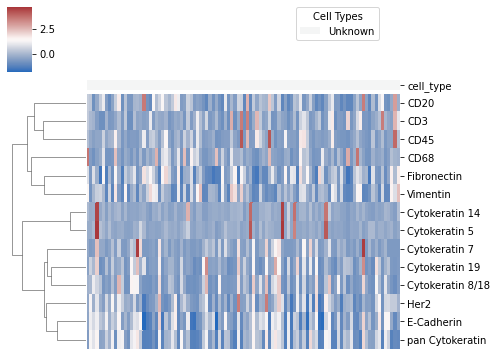

In [30]:
ast.type_clustermap(plot_name="./img/celltype_protein_cluster.png", threshold = 0.7, figsize=(7, 5))

Note: `threshold` is the probability threshold above which a cell is assigned to a cell type, default to 0.7. 

## 8. Hierarchical model specification <a class="anchor" id="8.-Hierarchical-model-specification"></a>

In the marker yaml file, the user can also add a section called `hierarchy`, which specifies the hierarchical structure of cell types. Here's an example:
```
hierarchy:
  immune:
    - B cells
    - T cells
    - macrophage
  epithelial:
    - epithelial(basal)
    - epithelial(luminal)
```

Some notes: 
1. The section would be accessed by key `hierarchy`.
2. In the section, the higher-levelled cell type names should be the keys.
3. The values in the section should also exist as the cell type names in the `cell_types` section. (e.g. if we have `"B cells"` in `marker["hierarchy"]["immune"]`, we should also be able to get `marker["cell_types"]["B cells"]`)

This section could be used to summarize the cell types assignment at a higher hierarchical level. (e.g. a cell is predicted as "immune" instead of "B cells" or "T cells")

In [31]:
hierarchy_probs = ast.assign_celltype_hierarchy()
hierarchy_probs.head()

,immune,epithelial
BaselTMA_SP41_186_X5Y4_3679,0.388475,0.318990
BaselTMA_SP41_153_X7Y5_246,0.473283,0.315430
BaselTMA_SP41_20_X12Y5_197,0.453717,0.300328
BaselTMA_SP41_14_X1Y8_84,0.444866,0.291041
BaselTMA_SP41_166_X15Y4_266,0.463366,0.283482


To make it more clear, here's a heatmap for the cell assignment in a higher hierarchy:

<img src="img/hierarchical_celltype_cluster.png" style="width:550px;height:400px;">

The way it is calculated is simply summing up the probabilities of the cell type assignments under the same hierarchy.

## 9. Using astir as command line tool <a class="anchor" id="9.-Using-astir-as-command-line-tool"></a>

`astir` could also be used as a command line tool with `csv` input. Here are some example.

To fit cell types on the sample `csv` file and marker with a design matrix, setting `n_init` to 3 and `batch_size` to 128:

In [32]:
!astir type ../../../astir/tests/test-data/test_data.csv ../../../astir/tests/test-data/jackson-2020-markers.yml data/test_data_type_assignments.csv --design ../../../astir/tests/test-data/design.csv --n_init 3 --batch_size 128  

training restart (final): 100%|███| 50/50 [155.15epochs/s, current loss: -591.9]
/Users/sunyunlee/Desktop/astir/astir/astir.py:192: UserWarning: Maximum epochs reached. More iteration may be needed to complete the training.
  warnings.warn(msg)


To fit cell states on the sample csv file and marker, setting `learning rate` to `5e-4`, `dropout_rate` to `0.2` and `batch_norm` to `True`:

In [33]:
!astir state ../../../astir/tests/test-data/test_data.csv ../../../astir/tests/test-data/jackson-2020-markers.yml data/test_data_type_assignments.csv --design ../../../astir/tests/test-data/design.csv --learning_rate 5e-4 --dropout_rate 0.2 --batch_norm True

/Users/sunyunlee/Desktop/astir/astir/models/cellstate.py:257: UserWarning: Delta loss batch size is greater than the number of epochs
  warnings.warn("Delta loss batch size is greater than the number of epochs")
training restart (final):   0%|          | 0/50 [?epochs/s, current loss: 883.6]


Moreover, astir could also be used as a converter which converts `rds` file with `SingleCellExperiment` to `csv` file. [see more details](./data_loading.ipynb#7.-Converting-rds-file-(with-data-as-SingleCellExperiment)-to-csv-file)

Run `astir -h`, `astir type -h`, `astir state -h` and `astir convert -h` in the command line for more details.